## Define Function and its Symmetry

In [42]:
import random

import torch
import matplotlib.pyplot as plt

from constants import TICK_SIZE, LABEL_FONT_SIZE, FIG_HEIGHT, DPI

plt.rcParams.update({
    'xtick.labelsize': TICK_SIZE,
    'ytick.labelsize': TICK_SIZE,
    'axes.labelsize': LABEL_FONT_SIZE,
    'legend.fontsize': LABEL_FONT_SIZE
})

n_features = 2
LAMBDA = 1
RHO = 1
DTYPE = torch.float32
SYMMETRY_DIM = 1
cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=DTYPE)

def f(state, cost_matrix=cost_matrix):
    """Evaluates f for a batch of states s and a cost_matrix.
    Args:
        state: torch.Tensor of shape (batch_size, n_features)
    Returns:
        torch.Tensor of shape (batch_size,)
    """
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

## Generate Dataset

In [2]:
N_SAMPLES = 100_000
s = torch.randn(N_SAMPLES, n_features, dtype=DTYPE)
y = f(s)

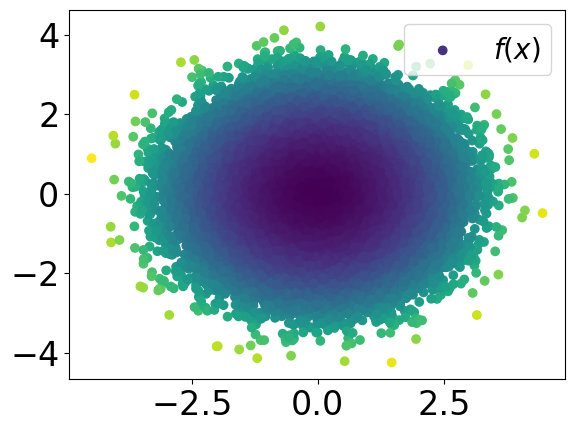

In [3]:
import matplotlib.pyplot as plt

plt.scatter(s.numpy()[:,0], s.numpy()[:,1], c=y.numpy(), label="$f(x)$")
plt.legend()
plt.show()

## Differential Symmetry Discovery

### Step 1: Learn Basis of Kernel at each Point

In [4]:
from scipy.spatial import KDTree
import numpy as np
from typing import Tuple, Dict

EPSILON_BALL = 0.05
EPSILON_LEVEL_SET = 0.005

def compute_neighborhood(data, epsilon) -> list:
    """Computes the neighborhood of each point in data.
    Args:
        data: torch.Tensor of shape (n_samples, n_features)
        epsilon: float"

    Returns:
        list of lists of integers, where the ith element is the list of indices of the neighbors of the ith point in data.
    """
    tree = KDTree(data.numpy())
    return tree.query_ball_tree(tree, epsilon)

def compute_kernel_samples(x_values, y_values, epsilon_ball, epsilon_level_set) -> Tuple[Dict, Dict]:
    """
    Computes a pointwise approximation of samples from the kernel of $f$.

    Args:
        neighbors: list of lists of integers, where the ith element is the list of indices of the neighbors of the ith point in data.
        y_values: torch.Tensor of shape (n_samples,), the readout of f at each point in data.
        epsilon_level_set: float, tolerance level for the level set.

    Returns:
        local_level_set: dictonary of length (n_samples,), each key is the index of a sample and the value is a tensor of shape (n_neighbors,) containing the indices of the neighbors that belong to the same level set
        kernel_vectors: dictonary of length (n_samples,), each key is the index of a sample and the value is a tensor of shape (n_kernel_vectors, n_features) containing a sample from the kernel distribution
    """
    neighbors = compute_neighborhood(x_values, epsilon_ball)

    # a) Approximate which samples are (i) close to a given sample and (ii) belong to the same level.
    local_level_set = {}
    for idx, y in enumerate(y_values):

        x_neighbors_idxs = np.array(neighbors[idx])
        x_neighbors_idxs = x_neighbors_idxs[x_neighbors_idxs != idx] #remove the point itself

        x_neighbors_level_set_membership = np.array(torch.abs(y_values[x_neighbors_idxs] - y) < epsilon_level_set)
        x_neighbors_level_set_idxs = x_neighbors_idxs[x_neighbors_level_set_membership]

        local_level_set[idx] = x_neighbors_level_set_idxs

    # b) Approximate the exponential map between samples in the same level set and in an \epsilon-ball via a linear approximation.
    kernel_vectors = {}
    for idx_sample, sample in enumerate(x_values):
        kernel_vectors[idx_sample] = torch.zeros((len(local_level_set[idx_sample]), n_features), dtype=DTYPE)

        for idx, neighbor_idx in enumerate(local_level_set[idx_sample]):
            kernel_vectors[idx_sample][idx] = x_values[neighbor_idx] - sample

    return kernel_vectors, local_level_set, neighbors


def compute_pointwise_basis(kernel_vectors: dict[int, torch.tensor], local_level_set: dict[int, torch.tensor]) -> dict[int, torch.tensor]:
    """
    Computes a 1-D pointwise basis of the kernel distribution at each sample if there exists at least one non-trivial tangent vector in the kernel.

    Args:
        kernel_vectors: dictonary of length (n_samples,), each key is the index of a sample and the value is a tensor of shape (n_kernel_vectors, n_features) containing a sample from the kernel distribution

    Returns:
        basis: dictonary of length (n_samples,), each key is the index of a sample and the value is a tensor of shape (n_kernel_vectors, n_features) containing a basis of the kernel distribution at the
    """
    basis = {}
    for idx_sample in kernel_vectors.keys():

        # idxs_points_in_local_level_set = list(local_level_set[idx_sample])
        # kernel_vectors_point = torch.empty(size=(0, n_features), dtype=DTYPE)
        # for idx_point in idxs_points_in_local_level_set:
        #     kernel_vectors_point = torch.vstack((kernel_vectors_point, kernel_vectors[idx_point]))
        kernel_vectors_point = kernel_vectors[idx_sample]
        if len(kernel_vectors_point) == 0:
            # No non-trivial tangent vectors known in the kernel so we can't compute a basis.
            continue
        elif len(kernel_vectors_point) == 1:
            # Only one non-trivial kernel vector, use this as approximation of the kernel at p.
            basis[idx_sample] = torch.nn.functional.normalize(kernel_vectors_point, p=2, dim=1).flatten()
        else:
            # There exists at least two non-trivial kernel vectors, compute a basis of dimension SYMMETRY_DIM of the Kernel distribution at the sample, normalized to have unit norm.
            # TODO, there is even in the 1-D case an identification problem here as the basis vector can point in two directions.
            _, _, _basis_vector = torch.pca_lowrank(kernel_vectors_point, q=SYMMETRY_DIM)
            _basis_vector = _basis_vector.T # PCA returns a vector of shape (1, n_features), we want it to be of shape (n_features, 1)
            basis[idx_sample] = torch.nn.functional.normalize(_basis_vector, p=2, dim=1).flatten()

    return basis

kernel, local_level_set, neighbors = compute_kernel_samples(s, y, EPSILON_BALL, EPSILON_LEVEL_SET)
basis = compute_pointwise_basis(kernel, local_level_set)

In [151]:
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


plot_lims = 0.085
SCALE_TANGENT_VECTOR = 0.03
directions = [1, -1, 1]

def plot_point_level_set_tangent(idx_points: list[int],
                                 ax=None,
                                 save_fig: bool = False,
                                 plot_balls: bool = False,
                                 plot_kernel: bool=False,
                                 fig_name:str=None,
                                 plot_y_label: bool=False):
    colors = ['g', 'b', 'm', 'c']

    # Get point coordinates before plotting to compute width
    p = s[idx_points[0]]
    p_x, p_y = p[0], p[1]
    x_min, x_max = p_x - plot_lims, p_x + plot_lims
    y_min, y_max = p_y - plot_lims, p_y + plot_lims

    # Compute aspect ratio and width
    aspect_ratio = (x_max - x_min) / (y_max - y_min)
    fig_width = FIG_HEIGHT * aspect_ratio

    if ax is None:
        fig, ax = plt.subplots(figsize=(fig_width, FIG_HEIGHT))

    ########## Set up legend
    legend_elements = [
        mlines.Line2D([], [], color="black", marker='o', linestyle='None', label=r'$p \in \hat{L}^{f}_{p}$', alpha=0.5),
    ]
    if plot_kernel:
        legend_elements += [
        mlines.Line2D([0], [0], color='black', marker='>', linestyle='-', markersize=8,
                  label=r'$U(p)$', linewidth=2, markevery=(1,)),        
        mlines.Line2D([], [], color='black', linestyle='--', label=r'$p \in L^{f}_{p}$')
        ]

    if plot_balls:
        legend_elements += [
            mlines.Line2D([], [], color='blue', marker='o', linestyle='None', label='$\epsilon_1$', alpha=1),
            mlines.Line2D([], [], color='orange', marker='o', linestyle='None', label='$\epsilon_2$', alpha=1),
            ]
        
    ########## Plot points
    for idx, idx_point in enumerate(idx_points):

        if plot_balls:
            circle = patches.Circle((p_x, p_y), EPSILON_BALL, fill=True, linestyle='--', linewidth=1, color="blue", alpha=0.2, label="$\epsilon_1$")
            ax.add_patch(circle)

            circle = patches.Circle((p_x, p_y), EPSILON_LEVEL_SET, fill=True, linestyle='--', linewidth=1, color="orange", alpha=0.2, label="$\epsilon_2$")
            ax.add_patch(circle)
            plot_balls=False

        p = s[idx_point]
        p_x = p[0]
        p_y = p[1]

        ax.scatter(s[local_level_set[idx_point]][:, 0], s[local_level_set[idx_point]][:, 1], c=colors[idx], alpha=0.5)
        ax.scatter(p_x, p_y, c=colors[idx], alpha=0.5)

        if plot_kernel:
            _basis_vector = basis[idx_point].numpy().flatten() * SCALE_TANGENT_VECTOR * directions[idx]
            ax.quiver(p_x, p_y, _basis_vector[0], _basis_vector[1], angles='xy', scale_units='xy', color=colors[idx], scale=1)

        circle_radius = s[idx_point].norm()
        circle = patches.Circle((0, 0), circle_radius, fill=False, linestyle='--', linewidth=1, edgecolor=colors[idx])
        ax.add_patch(circle)
        ax.set_aspect('equal')



    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)



    ax.legend(handles=legend_elements, ncols=3, loc="upper right", fontsize=LABEL_FONT_SIZE*1.5)
    ax.set_xlabel(r'$p_1$', fontsize=LABEL_FONT_SIZE*1.5)
    if plot_y_label:
        ax.set_ylabel(r'$p_2$', fontsize=LABEL_FONT_SIZE*1.5)
    ax.grid(True)

    if save_fig:
        fig.savefig(fig_name, dpi=DPI, bbox_inches='tight')

In [152]:
def orthogonal_projec(projection, p, subspace):
    """
    Projects a batched point p via a projection and computes its orthogonal component with respect to a given subspace.
    Args:
        generator: (d, n, n)
        p: (b, n)
        subspace: (b, n, d)
    Returns:
        p_ortho: (b, n)
    """

    # Project p into generator space: (b, d, n)
    p_proj = torch.einsum('dnm,bm->bdn', projection, p)

    # Reshape p_proj as (b, n) by summing across generator directions (if 1D kernel)
    # If d=1, this collapses to a single vector:
    if projection.shape[0] == 1:
        p_proj = p_proj[:, 0, :]  # shape (b, n)
    else:
        raise ValueError("Only 1D subspace supported in this projection version.")

    # Compute projection of p_gen into basis (b, n)
    subspace_pinv = torch.linalg.pinv(subspace)  # (b, d, n)
    coeffs = torch.einsum('bdn,bn->bd', subspace_pinv, p_proj)  # (b, d)
    p_subspace = torch.einsum('bnd,bd->bn', subspace, coeffs)     # (b, n)

    # Orthogonal component
    p_ortho = p_proj - p_subspace

    return p_ortho

In [153]:
def plot_kernel_and_projection(idx_points: list[int],
                               ax=None,
                               save_fig: bool = False,
                               fig_name: str = None,
                               plot_y_label: bool = False,
                               quiver_scale:float=50,
                               ortho_scale:float=1):
    colors = ['g', 'b', 'm', 'c']
    assert len(idx_points) < 5, "For coloring purposes at most 4 points."

    batch_points = s[idx_points]
    batch_bases = torch.vstack([basis[i] for i in idx_points]).unsqueeze(-1)

    # Compute kernel and orthogonal component
    g_0 = torch.tensor([[0, -1], [-1, 0]], dtype=DTYPE, requires_grad=True).unsqueeze(0)
    ortho_comp = orthogonal_projec(g_0, batch_points, batch_bases)
    ground_truth_kernel = -torch.einsum('dnm, bm->bdn', g_0, batch_points).squeeze(1)
    ortho_comp_scaled = ortho_comp * ortho_scale

    # Compute plot limits from the first point
    p = s[idx_points[0]]
    p_x, p_y = p[0], p[1]
    x_min, x_max = p_x - plot_lims, p_x + plot_lims
    y_min, y_max = p_y - plot_lims, p_y + plot_lims
    aspect_ratio = (x_max - x_min) / (y_max - y_min)
    fig_width = FIG_HEIGHT * aspect_ratio

    if ax is None:
        fig, ax = plt.subplots(figsize=(fig_width, FIG_HEIGHT))

    # Add level sets
    for idx, idx_point in enumerate(idx_points):
        circle_radius = s[idx_point].norm()
        circle = patches.Circle((0, 0), circle_radius, fill=False, linestyle='--',
                                linewidth=1, edgecolor=colors[idx])
        ax.add_patch(circle)

    # Scatter plot for batch points
    ax.scatter(batch_points.numpy()[:, 0], batch_points.numpy()[:, 1],
               color=(0.0, 0.5, 0.5), label=r"$p \in \mathcal{B}$")

    # Quiver plots
    
    ax.quiver(batch_points.numpy()[:, 0], batch_points.numpy()[:, 1],
              batch_bases.numpy()[:, 0, 0]*directions, batch_bases.numpy()[:, 1, 0]*directions,
              angles='xy', scale_units='xy', scale=quiver_scale,
              color=colors[:len(idx_points)], label=r"$U_p$", alpha=1)

    ax.quiver(batch_points.numpy()[:, 0], batch_points.numpy()[:, 1],
              ground_truth_kernel.detach().numpy()[:, 0], ground_truth_kernel.detach().numpy()[:, 1],
              angles='xy', scale_units='xy', scale=quiver_scale,
              color='black', label=r"$U_{\theta}^{\mathrm{lin}} \cdot p$", alpha=0.7)

    ax.quiver(batch_points.numpy()[:, 0], batch_points.numpy()[:, 1],
              ortho_comp_scaled.detach().numpy()[:, 0], ortho_comp_scaled.detach().numpy()[:, 1],
              angles='xy', scale_units='xy', scale=quiver_scale,
              color="red", label="Orth. Comp")

    # Axis formatting
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    ax.set_xlabel(r'$p_1$', fontsize=LABEL_FONT_SIZE * 1.5)
    if plot_y_label:
        ax.set_ylabel(r'$p_2$', fontsize=LABEL_FONT_SIZE * 1.5)

    ax.legend(ncols=2, loc="upper right", fontsize=LABEL_FONT_SIZE*1.5)
    ax.grid(True)

    if save_fig:
        fig.savefig(fig_name, dpi=DPI, bbox_inches='tight')


In [154]:
def plot_all_three(idx_groups: list[list[int]], save_fig: bool = False, fig_name: str = None):
    fig, axes = plt.subplots(1, 3, figsize=(FIG_HEIGHT*3, FIG_HEIGHT), constrained_layout=True)

    # Plot first panel
    plot_point_level_set_tangent(
        idx_points=idx_groups,
        plot_balls=True,
        plot_kernel=False,
        plot_y_label=True,
        ax=axes[0]
    )

    # Plot second panel
    plot_point_level_set_tangent(
        idx_points=idx_groups,
        plot_balls=False,
        plot_kernel=True,
        plot_y_label=False,
        ax=axes[1]
    )

    # Plot third panel
    plot_kernel_and_projection(
        idx_points=idx_groups,
        plot_y_label=False,
        ax=axes[2]
    )

    if save_fig:
        fig.savefig(fig_name, dpi=DPI, bbox_inches='tight')

    plt.show()


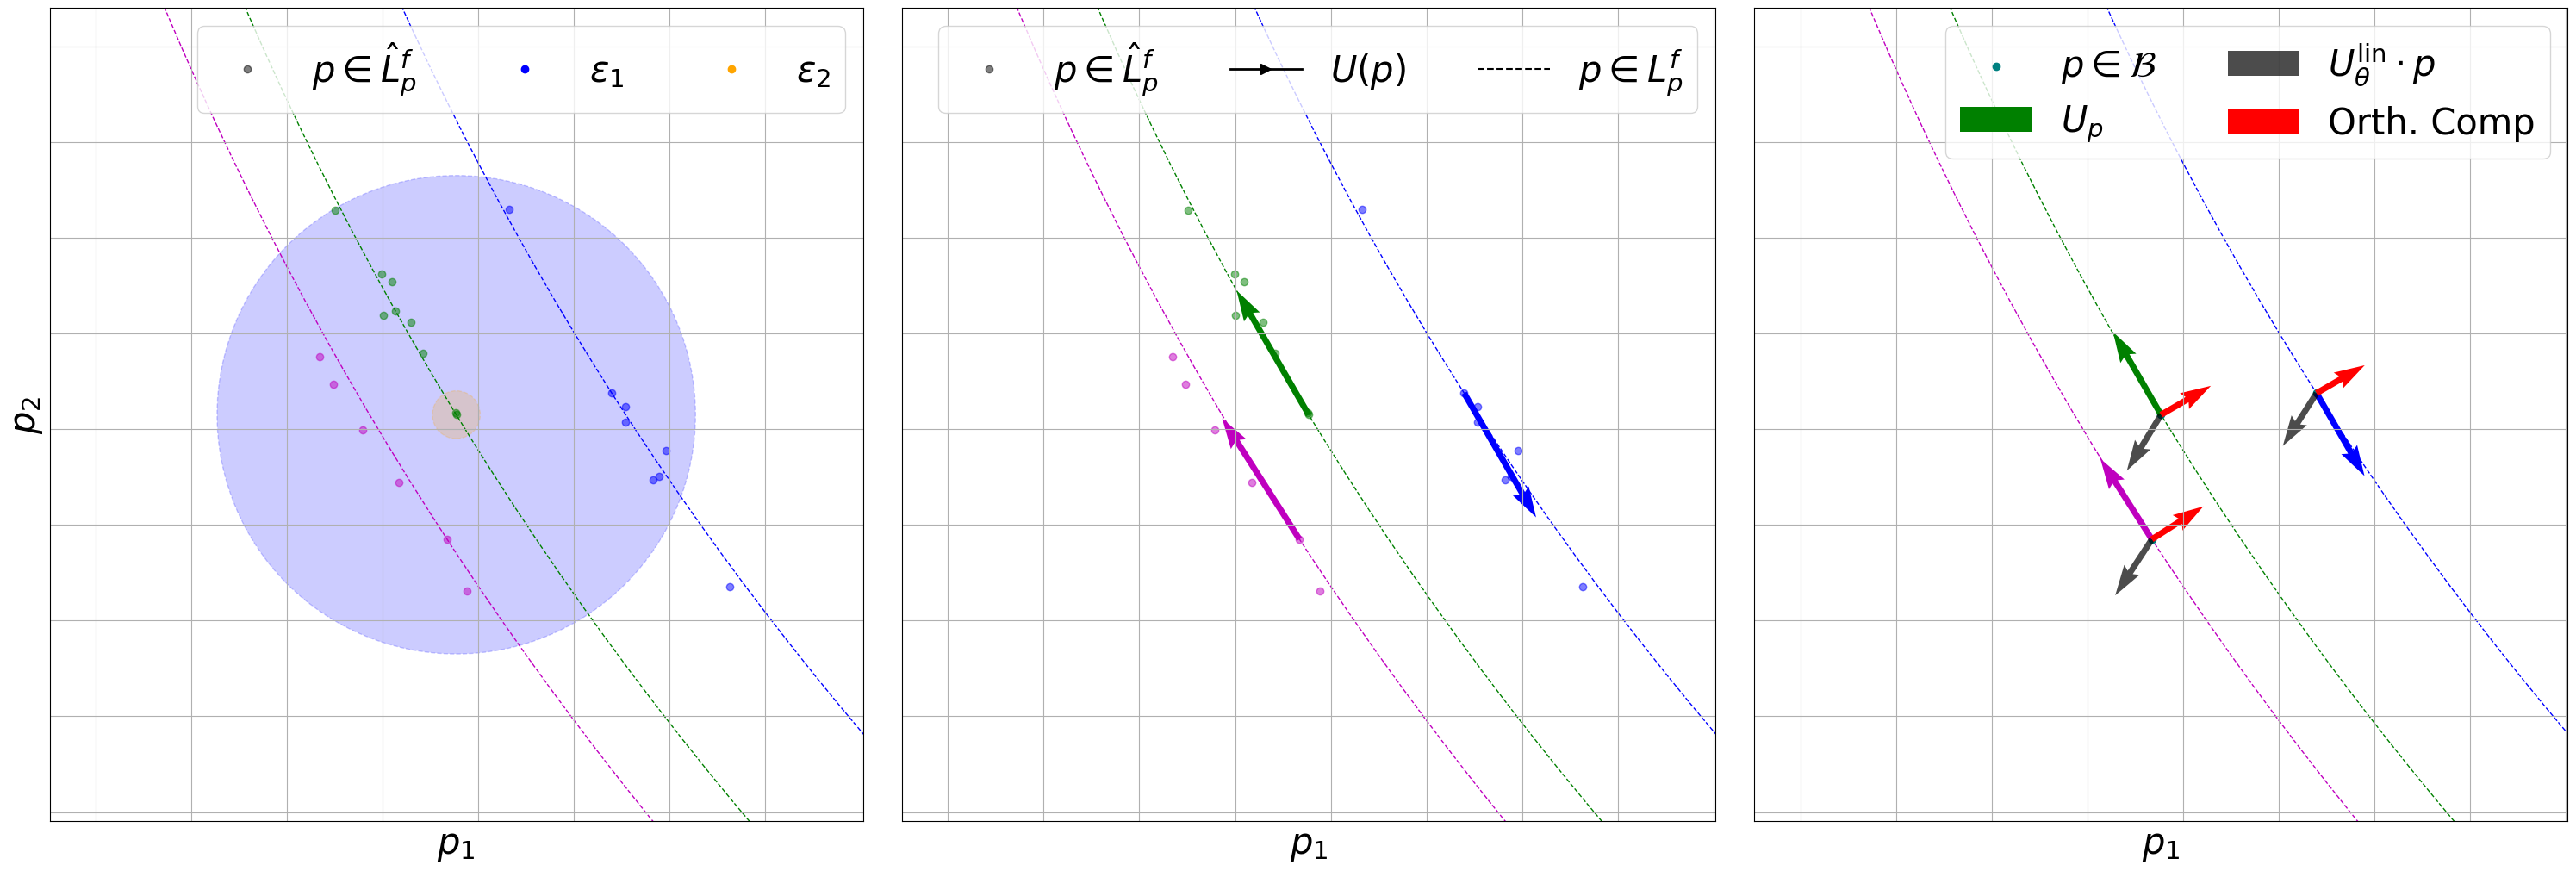

In [155]:
IDX_POINT=66
idxs_points_to_plot=[IDX_POINT, neighbors[IDX_POINT][3], neighbors[IDX_POINT][4]]

plot_all_three(
    idx_groups=idxs_points_to_plot,
    save_fig=True,
    fig_name="frame_estimation.png"
)
